In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm
import time
import pymrmr

from copy import deepcopy
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [7]:
mask = 'new'
space = 'subject'

if space == 'template':
    negative_idx = np.array ((np.arange(22) + 27).tolist() + (np.arange(48) + 106).tolist())
    label_path = 'label_154.xlsx'
    if mask == 'new':
        data_path = 'data_154_newmask.xlsx'
    elif mask == 'old':
        data_path = 'data_154_oldmask.xlsx'
    else:
        print('mask {} not supported'.format(mask))
    
elif space == 'subject':
    negative_idx = np.array ((np.arange(22) + 27).tolist() + (np.arange(35) + 97).tolist())
    label_path = 'label_132.xlsx'
    if mask == 'new':
        data_path = 'data_132_newmask_subjectspace.xlsx'
    elif mask == 'old':
        data_path = 'data_132_oldmask_subjectspace.xlsx'
    else:
        print('space {} not supported'.format(mask))
else:
    print('mask {} not supported'.format(space))
    
data = pd.read_excel(data_path, index_col=0, sheet_name=0)
label = pd.read_excel(label_path, index_col=0, sheet_name=0)
features = np.array (list(data.columns))

predict = 'Digit Span Forward T1'

print(data.head(), label.head())

       ak-left_rostral-mean  ak-left_rostral-std  ak-left_rostral-skew  \
HT102              0.743415             0.132570             -0.139329   
HT103              0.817765             0.136033              0.149619   
HT105              0.716597             0.118742              0.327498   
HT106              0.782687             0.131543              0.061009   
HT107              0.731944             0.129686              0.131464   

       ak-left_rostral-kurt  ak-left_rostral-etrp  ak-right_rostral-mean  \
HT102              0.018893              5.381851               0.781545   
HT103              1.238020              5.542772               0.790646   
HT105              0.808425              5.523633               0.725885   
HT106              0.821854              5.457917               0.748640   
HT107              0.158863              5.548673               0.698416   

       ak-right_rostral-std  ak-right_rostral-skew  ak-right_rostral-kurt  \
HT102              0.

In [8]:
def greedy_forward_SVM(F, y, num_feature, num_selected, num_repeats, num_test, C_val, Gamma_val, eps_val):
    '''
    Greedy Forward SVM by Dr. Alp
    Args:
        F: data
        y: label
        num_feature: number of feature in total. should be 120 but only 100
        num_selected: number of feature selected
        num_repeats: iter of repeat to avoid noise
        num_test: number of test sample
        C_val: c value as SVM hypter parameter
        Gamma_val: gamma value as SVM hyper parameter
        eps_val: eplison value as SVM hyper parameter
    '''
    best_acc_featsize = np.zeros((num_feature,))  ### accuracy with best subset of different sizes
    all_feat_remained = np.arange(num_feature)
    feat_order = list()

    num_samples = F.shape[0]

    for i in range(num_selected):  ## adds one feature per step
        # iterating through all possible i

        train_acc_cur = np.zeros((len(all_feat_remained), num_repeats))
        test_acc_cur = np.zeros((len(all_feat_remained), num_repeats))
        train_acc_avg = np.zeros((len(all_feat_remained),))
        test_acc_avg = np.zeros((len(all_feat_remained),))
        # print("%d-th feature selection" % ( i+1) )

        for j in range(len(all_feat_remained)):  ## selects one feature out of the remaining ones

            cur_feat_list = deepcopy(feat_order)
            cur_feat_list.append(all_feat_remained[j])
            X = F[:, cur_feat_list]
            # print("%d-th feature selection and feature list= [%s]" % ( i+1, ', '.join(map(str, cur_feat_list))))

            for iter in range(num_repeats):
                # print("%d-th feature selection and %d-th iteration and feature list= [%s]" % ( i+1, iter+1,', '.join(map(str, cur_feat_list))))

                np.random.seed(3 * iter + 10)
                inds = np.random.choice(len(y), num_test)

                X_test = X[inds, :]
                y_test = y[inds]
                X_train = np.delete(X, inds, 0)
                y_train = np.delete(y, inds)

                clf = svm.SVR(C=C_val, epsilon=eps_val, kernel='rbf', degree=4, gamma=Gamma_val, tol=0.001,
                              cache_size=200, max_iter=-1)
                clf.fit(X_train, y_train)
                predicted_train_labels = clf.predict(X_train)
                train_score = clf.score(X_train, y_train)
                # train_error= sum( [1. for k in pred_diff_train if k != 0])/len(predicted_train_labels)
                train_acc_cur[j, iter] = train_score
                predicted_test_labels = clf.predict(X_test)
                test_score = clf.score(X_test, y_test)
                # test_error= sum( [1. for k in pred_diff_test if k != 0])/len(predicted_test_labels)
                test_acc_cur[j, iter] = test_score
                # print("%d-th feature, current list [%s], and its acc= %f" % ( j+1, ', '.join(map(str, cur_feat_list)), test_acc_cur[ j, iter] ))

        for k in range(len(all_feat_remained)):
            train_acc_avg[k] = np.mean(train_acc_cur[k, :])
            test_acc_avg[k] = np.mean(test_acc_cur[k, :])

        best_acc_featsize[i] = np.max(test_acc_avg)
        best_testacc_ind = np.unravel_index(test_acc_avg.argmax(), test_acc_avg.shape)
        feat_order.append(all_feat_remained[best_testacc_ind])
        # print(" current best feature index= %d" %  (all_feat_remained[best_testacc_ind]) )

        all_feat_remained = np.delete(all_feat_remained, best_testacc_ind, 0)

    return feat_order, best_acc_featsize

In [9]:
NegativeOnly = True

if NegativeOnly:
    X = data.iloc[negative_idx]
    y = label.iloc[negative_idx]['Digit Span Backward T1']
    
else:
    X = data
    y = label['Digit Span Backward T1']

drop = y.notnull()

X = X[drop]
y = y[drop]    

y = y.to_frame()

feature_coulmn = X.columns
label_column = y.columns
print(feature_coulmn, label_column)

X = (X.values)
y = (y.values)

Index(['ak-left_rostral-mean', 'ak-left_rostral-std', 'ak-left_rostral-skew',
       'ak-left_rostral-kurt', 'ak-left_rostral-etrp', 'ak-right_rostral-mean',
       'ak-right_rostral-std', 'ak-right_rostral-skew',
       'ak-right_rostral-kurt', 'ak-right_rostral-etrp',
       ...
       'mk-right_caudal-mean', 'mk-right_caudal-std', 'mk-right_caudal-skew',
       'mk-right_caudal-kurt', 'mk-right_caudal-etrp',
       'mk-corpus_callosum-mean', 'mk-corpus_callosum-std',
       'mk-corpus_callosum-skew', 'mk-corpus_callosum-kurt',
       'mk-corpus_callosum-etrp'],
      dtype='object', length=280) Index(['Digit Span Backward T1'], dtype='object')


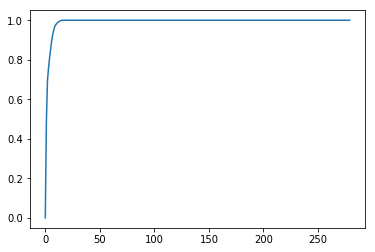

In [10]:
# TODO
Xs = X - np.mean(X, axis=0)[None, :]
ncomp = 15
pca = PCA(n_components=ncomp, whiten=True, svd_solver='randomized')
pca.fit(Xs)
sigma = pca.singular_values_
PoV = [np.sum(sigma[:i]**2)/np.sum(sigma**2) for i in range(X.shape[1])]
plt.plot(np.arange(X.shape[1]), PoV)
Z = pca.transform(Xs)

[-2.   -1.67 -1.33 -1.   -0.67 -0.33  0.    0.33  0.67  1.    1.33  1.67
  2.    2.33  2.67]
(0.8240081481370484, 0.0, 0.0, 1.0)


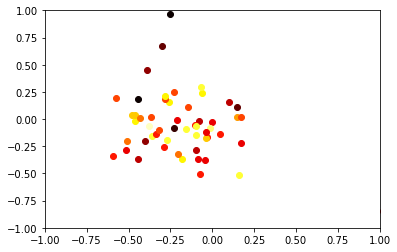

In [11]:
print(np.unique(y))
import matplotlib.cm as cm
print (cm.hot(0.3))
plt.xlim(-1,1)
plt.ylim(-1,1)

for i in range (Z.shape[0]):
        
    plt.scatter(Z[i,0], Z[i,1], color=cm.hot((y[i]+2)/5))
plt.show()

In [12]:
Ztr, Zts, ytr, yts = train_test_split(Z, y, test_size=0.33)
print(Ztr.shape)

(38, 15)


In [13]:
clf = svm.SVR(C=100, epsilon=0.5, kernel='rbf', degree=4, gamma=1, tol=0.001, cache_size=200, max_iter=-1)

clf.fit(Ztr, ytr)

ytr_hat = clf.predict(Ztr)
yts_hat = clf.predict(Zts)

train_score = r2_score(ytr, ytr_hat)
test_score = r2_score(yts, yts_hat)

# train_score = clf.score(Ztr, ytr)
# yhat = clf.predict(Zts)
# test_score = clf.score(yts, yhat)
print(train_score, test_score)

0.8579533216050386 -0.046743998373826035


/home/xu/anaconda3/envs/cs231/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
# Normalize the data
Xs = (X - np.mean(X, axis=0)[None,:])/np.std(X, axis=0)[None,:]
Xs = np.round(Xs, 1) # discrete the data
y = y # y is already discrete number

In [15]:
Xdf = pd.DataFrame(Xs, columns=feature_coulmn)
ydf = pd.DataFrame(y, columns=label_column)
yXdf = pd.concat([ydf, Xdf], axis=1, join='inner')

In [40]:
selected_feat = pymrmr.mRMR(yXdf, 'MID', 10)
print(selected_feat)

['eas_De_par-right_caudal-etrp', 'eas_De_perp-corpus_callosum-kurt', 'eas_De_perp-right_middle-kurt', 'mk-left_caudal-kurt', 'eas_De_par-corpus_callosum-skew', 'ias_Da-left_rostral-mean', 'FA-left_rostral-skew', 'awf-right_middle-skew', 'ak-left_rostral-etrp', 'ak-right_caudal-skew']


In [44]:
if NegativeOnly:
    X = data.iloc[negative_idx]
    #X = data.iloc[negative_idx][selected_feat]
    y = label.iloc[negative_idx]['Digit Span Backward T1']
    
else:
    X = data[selected_feat]
    y = label['Digit Span Backward T1']

drop = y.notnull()

X = X[drop]
y = y[drop]  

Xnp = (X.values)
ynp = (y.values)

In [37]:
Xtr, Xts, ytr, yts = train_test_split(Xnp, ynp, test_size=0.33)
# clf = svm.SVR(C=1000, epsilon=0.5, kernel='rbf', degree=4, gamma=0.01, tol=0.001, cache_size=200, max_iter=-1)
clf = RandomForestRegressor(n_estimators=128, n_jobs=-1)
clf.fit(Xtr, ytr)

ytr_hat = clf.predict(Xtr)
yts_hat = clf.predict(Xts)

train_score = r2_score(ytr, ytr_hat)
test_score = r2_score(yts, yts_hat)

# train_score = clf.score(Ztr, ytr)
# yhat = clf.predict(Zts)
# test_score = clf.score(yts, yhat)
print(train_score, test_score)

0.8900773432593936 -0.03900103653569653


In [46]:
start_time = time.time()

num_feature = Xnp.shape[1]
num_test = 20
num_repeats = 5  ## shows number of times we shuffle the data and test on testing
train_accuracies = [0] * num_repeats
test_accuracies = [0] * num_repeats

tot_num = Xnp.shape[0]

num_selected = 10
eps = 0.5

# C_range = np.logspace(-3, 3, num=5)
# gamma_range = np.logspace(-5, 4, 5)

C_range = np.array([1000])
gamma_range = np.array([0.31623])

test_acc_all = np.zeros((C_range.shape[0], gamma_range.shape[0], num_feature))
selected_feat = np.zeros((C_range.shape[0], gamma_range.shape[0], num_selected))

print("Start")
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        a1, a2 = greedy_forward_SVM(Xnp, ynp, num_feature, num_selected, num_repeats, num_test, C_range[i], gamma_range[j],
                                    eps)
        a3 = np.asarray(a1)
        test_acc_all[i, j, :] = a2
        selected_feat[i, j, :] = a3
        print("(", C_range[i], ",", gamma_range[j], ") value of (C, Gamma), and best feat indices=", a3)

max_ind = np.unravel_index(test_acc_all.argmax(), test_acc_all.shape)
print("maximum test accuracy= %.3f, achieved by using %d features and ( C, Gamma, eps)= ( %.5f, %.5f, %.5f) from 14 metrics" % (
test_acc_all[max_ind], max_ind[2] + 1, C_range[max_ind[0]], gamma_range[max_ind[1]], eps))
print("Selected feature for 3xiter=", selected_feat[max_ind[0], max_ind[1], 0:max_ind[2] + 1])
print(features[np.array(selected_feat[max_ind[0], max_ind[1], 0:max_ind[2] + 1], dtype=np.int)])
# print("\nMaximum Train Accuracy with 100 iteration: %f " % np.max(train_acc_all), "%")
# print("\nMaximum Test Accuracy: %f, by feature indices= %s " % ( np.max(test_acc_avg), subset_indices[best_testacc_ind[0]] ) )

# print("\nall accuracies:", test_acc_avg)

end_time = time.time()
tot_time = end_time - start_time
print("total time=", tot_time)


Start
( 1000 , 0.31623 ) value of (C, Gamma), and best feat indices= [195 127 162  56  26  51  50  46  36 146]
maximum test accuracy= 0.526, achieved by using 8 features and ( C, Gamma, eps)= ( 1000.00000, 0.31623, 0.50000) from 14 metrics
Selected feature for 3xiter= [195. 127. 162.  56.  26.  51.  50.  46.]
['ias_Da-left_caudal-mean' 'eas_De_perp-left_caudal-skew'
 'FA-left_caudal-skew' 'awf-left_caudal-std' 'ak-right_caudal-std'
 'awf-right_middle-std' 'awf-right_middle-mean' 'awf-left_middle-std']
total time= 48.06888198852539
